In [17]:
#ignore
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import folium

import datetime

from IPython.core.display import HTML

EARTH_RADIUS = 6371 # km
%matplotlib inline

![Interface screenshots](screenshots.jpg)

In [3]:
#ignore
df = pd.read_csv('pings.csv',header=None,names=['time','acc','lon','lat'])
df.time = pd.to_datetime(df.time, infer_datetime_format=True) + datetime.timedelta(hours=6)
df = df.set_index(df.time)
df.sort_index(inplace=True)
df['dt'] = df.time.diff().astype('<m8[s]').fillna(9999999)
# Get rid of time column (now resides in index)
df.drop('time', axis=1, inplace=True)
# Remove points in the US
df.drop(df.index[0:2], inplace=True)
df.head()

,acc,lon,lat,dt
time,,,,
2015-06-02 22:36:42.000000,10,100.753538,13.704107,153622
2015-06-02 22:37:47.029999,18,100.757832,13.719487,65
2015-06-02 22:39:15.039000,8,100.749045,13.729378,88
2015-06-02 22:40:44.036000,12,100.726632,13.729938,88
2015-06-02 22:42:13.030999,28,100.702625,13.732482,88


## Labels days

In [4]:
#ignore
df['label'] = np.nan
df['notes'] = np.nan

In [5]:
#ignore
df.loc['20150607','label'] = 'Ho Chi Minh to Da Lat'
df.loc['20150610','label'] = 'Da Lat to Buon Ma Thuot'
df.loc['20150611','label'] = 'Buon Ma Thuot to Pleiku'
df.loc['20150613','label'] = 'Pleiku to Hoi An'
df.loc['20150617','label'] = 'Hoi An to Hue'
df.loc['20150619','label'] = 'Hue to Phong Nha'
df.loc['20150620','label'] = 'Phong Nha'
df.loc['20150622','label'] = 'Phong Nha to Vinh'
df.loc['20150623','label'] = 'Vinh to Ninh Binh'
df.loc['20150625','label'] = 'Ninh Binh to Ha Noi'

df.loc['20150629','label'] = 'Ha Noi to Phonsavan'
df.loc['20150630','label'] = 'Ha Noi to Phonsavan'
df.loc['20150701','label'] = 'Plain of Jars'
df.loc['20150702','label'] = 'Phonsavan to Luang Prabang'
df.loc['20150704','label'] = 'Luang Prabang to Chiang Rai'
df.loc['20150705','label'] = 'Luang Prabang to Chiang Rai'
df.loc['20150706','label'] = 'Chiang Rai'
df.loc['20150708','label'] = 'Chiang Rai to Chiang Mai'
df.loc['20150710','label'] = 'Chaing Mai Grand Canyon'

df.loc['20150711','label'] = 'Chaing Mai to Pai'
df.loc['20150712','label'] = 'Pai'
df.loc['20150713','label'] = 'Pai'
df.loc['20150714','label'] = 'Pai to Caves and Back'
df.loc['20150716','label'] = 'Pai to Mountain'
df.loc['20150717','label'] = 'Pai to Chiang Mai'

df.loc['20150824','label'] = 'Chiang Mai to Bangkok'
df.loc['20150825','label'] = 'Chiang Mai to Bangkok'
df.loc['20150826','label'] = 'Bangkok to Pinang'
df.loc['20150827','label'] = 'Bangkok to Pinang'
df.loc['20150829','label'] = 'Pinang'
df.loc['20150831','label'] = 'Pinang to Tanah Rata'

df.loc['20150902','label'] = 'Tanah Rata to Kuala Lumpur'

In [6]:
#ignore
df['latlon'] = df[['lat','lon']].apply(tuple, axis=1)
df = df['20150605':'20150628']

In [7]:
#ignore
def haversine(loc1, loc2):
    lat1, lon1, lat2, lon2 = map(np.radians, [loc1[0],loc1[1],loc2[0],loc2[1]])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    return c * EARTH_RADIUS

def dhaversine(dlat,dlon):
    return haversine((0.0,0.0),(dlat,dlon))

In [8]:
#ignore
df.sort_index(inplace=True)

#df['dr'] = dhaversine( df.lat.diff(), df.lon.diff() )
#df['dv'] = df.dr.diff()

# Compute dr's by day
# (in case the start recording location is different from the end location the day before)
dr = df.groupby(pd.TimeGrouper('D')).apply(lambda x: dhaversine( x.lat.diff(), x.lon.diff() )).fillna(0)
dr.index = dr.index.droplevel(0)
df['dr'] = dr
df['drdt'] =  df['dr'] / (df.dt/3600)

dv = df.groupby(pd.TimeGrouper('D')).apply(lambda x: x.dr.diff()).fillna(0)
dv.index = dv.index.droplevel(0)
df['dv'] = dv
df['dvdt'] = df['dv'] / (df.dt/3600)

# Cumulative distance by day
df['cumr'] = df.groupby([df.index.month, df.index.day])['dr'].apply(lambda x: x.cumsum())

In [16]:
#ignore
def inline_map(m, width=600, height=500):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: 100%; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed

m = folium.Map(location=[df.lat.mean(), df.lon.mean()], zoom_start=5,tiles='OpenStreetMap')

group = df.groupby(pd.TimeGrouper('D'))
c = sns.color_palette('hls', n_colors=len(group)).as_hex()
for i, g in enumerate(group):
    if len(g[1]['cumr']) > 0 and g[1]['cumr'].iloc[-1] > 60:
        m.line(g[1].latlon, line_color=c[i], line_opacity=0.9, line_weight=7, popup=g[1]['label'][0])
        city_label = g[1]['label'][0].split('to')
        m.polygon_marker(g[1].latlon[0], popup=city_label[0], fill_opacity=0.8, fill_color='#ff0000')
    
inline_map(m)

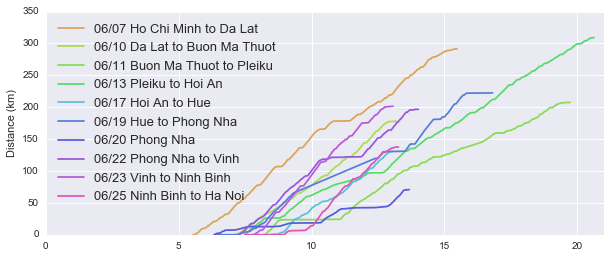

In [34]:
#ignore
plt.figure(figsize=(10,4))
group = df.groupby(pd.TimeGrouper('D'))
c = sns.color_palette('hls', n_colors=len(group)).as_hex()
for i, g in enumerate(group):
    if len(g[1]['cumr']) > 10 and g[1]['cumr'].iloc[-1] > 60:
        #print(g[1]['cumr'])
        plt.plot(g[1].index.hour + g[1].index.minute/60 + g[1].index.second/3600,
                g[1]['cumr'], color=c[i],
                 label=g[1].index[0].strftime('%m/%d')+' '+g[1]['label'][0])

plt.legend(loc=2, fontsize=13)

plt.xlim(0,21)
plt.ylabel('Distance (km)')
plt.show()

## A single day of riding

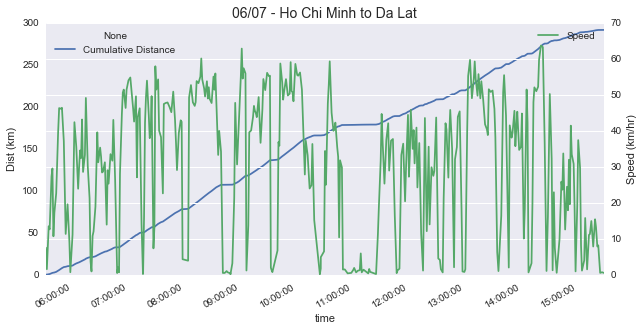

In [36]:
#ignore
day = '20150607'
plt.figure(figsize=(10,5))
df[day].iloc[1:].cumr.plot()
plt.ylabel('Dist (km)')
plt.legend(['Cumulative Distance'])

df[day].iloc[1:].drdt.plot(secondary_y=True)
plt.legend(['Speed'])
plt.title(df[day].index[0].strftime('%m/%d') + ' - ' + df.label[day][0], fontsize=14)
plt.ylabel('Speed (km/hr)')
plt.show()

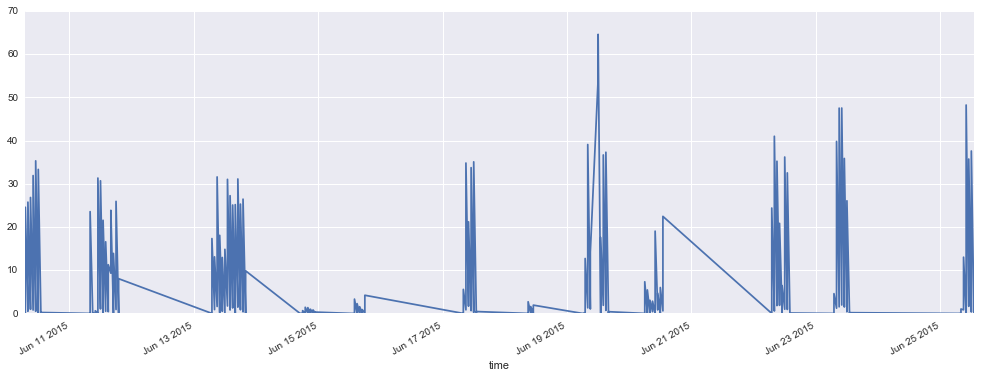

In [32]:
#ignore
plt.figure(figsize=(17,6))
sday = '20150610'
eday = '20150625'
group = df[sday:eday].groupby(pd.TimeGrouper('H')).apply(lambda x: x.dr.cumsum())
group.index = group.index.droplevel(1)
#group.filter(lambda group: group.index[0] > 0)
# Days with over 50 km traveled
#group = group.filter(lambda group: group.cumr.iloc[-1] > 50.0)
group.plot(subplots=False, layout=(3,3))
plt.show()

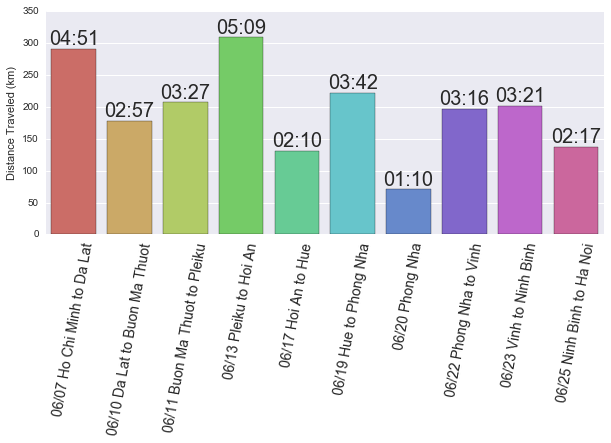

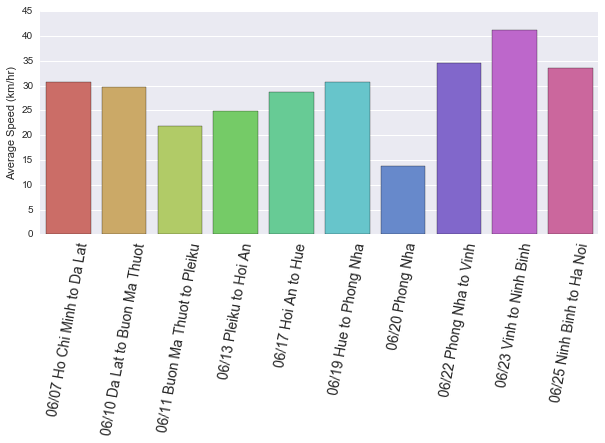

In [29]:
#ignore
group = df.groupby(pd.TimeGrouper('D'))

plt.figure(figsize=(10,4))
trips = pd.DataFrame( group.dr.agg(sum), index=group.indices).sort_index()
trips['drdt'] = group.drdt.mean()
# Filter extremes
trips = trips[ trips['dr'] > 50]
trips = trips[ trips['dr'] < 600]
trips['dur'] = group.dt.last() - group.dt.first()

# Obnoxious default formatting for dates
date_labels = trips.index.strftime('%m/%d')
date_labels = [ l for l in group.label.first() if type(l) is not float]
date_labels = [ ti.strftime('%m/%d') + ' ' + l  for (l,ti) in zip(date_labels, trips.index)]

c = sns.color_palette('hls', n_colors=len(trips))
sns.barplot(trips.index, trips['dr'], palette=c)
plt.xticks(rotation=80, fontsize=14)
plt.gca().set_xticklabels(date_labels)
plt.ylabel('Distance Traveled (km)')

for i in range(len(trips)):
    td = datetime.timedelta(seconds=trips.iloc[i].dr)
    plt.gca().annotate(str(td)[2:7], xy=(i, trips.iloc[i].dr),
                       horizontalalignment='center', verticalalignment='bottom', fontsize=20)


plt.figure(figsize=(10,4))

sns.barplot(trips.index, trips['drdt'], palette=c)
plt.xticks(rotation=80, fontsize=14)
plt.gca().set_xticklabels(date_labels)
plt.ylabel('Average Speed (km/hr)')

plt.show()

In [34]:
m = folium.Map(location=[df.lat.mean(), df.lon.mean()], zoom_start=5,tiles='OpenStreetMap')
m.line(df['20150620'].latlon)
    
inline_map(m)